I decided to go for Mission 1: train a CNN to distinguish cancer samples from control samples. I used Python 3.7 and the following third-party packages: pandas, numpy, matplotlib, sklearn, keras, tensorflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

To select a cancer cohort, I looked a little bit into the data. First I looked at the mutation frequencies of all cancer types (in the total counts table), assuming that a cancer with more and higher frequencies would be easier to classify. Based on the below plots I therefore excluded everything but Daisy, Snowdrop and Lavender.

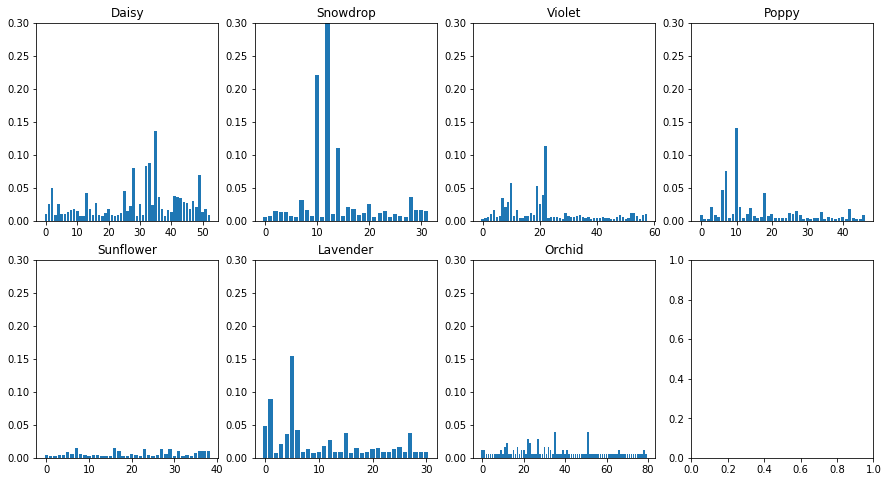

In [2]:
total_counts = pd.read_excel("QG_DS_ML_hiringChallenge.xlsx", sheet_name=2, header=1)
cancers = ["Daisy", "Snowdrop", "Violet", "Poppy", 
           "Sunflower", "Lavender", "Orchid"]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
for idx, cancer in enumerate(cancers):
    freqs = [x for x in total_counts[cancer] if not np.isnan(x)]
    ax.flat[idx].bar(x=np.arange(len(freqs)), height=freqs)
    ax.flat[idx].set_title(cancer)
    ax.flat[idx].set_ylim([0, 0.3])

Next, I looked into the meta data table to count how many samples per cancer type I have. The result eliminated everything but Daisy (and even the Daisy count of 44 is rather low to train a CNN).

In [3]:
meta_data = pd.read_excel("QG_DS_ML_hiringChallenge.xlsx", sheet_name=1,
                          usecols="K:MX", nrows=46, header=0, index_col=0)
meta_data.loc["Cancer type"].value_counts()

Daisy        44
Poppy        24
Snowdrop     21
Sunflower    11
Lavender     10
Orchid        8
Violet        5
Name: Cancer type, dtype: int64

I extracted the sample IDs of all Control and Daisy samples (a total of 272 samples.)

In [4]:
sampleids_all = set(meta_data.columns[
    (meta_data.loc['Clinical diagnosis'] == "CONTROL") | (meta_data.loc['Cancer type'] == 'Daisy')
])
len(sampleids_all)

272

I saved the table indices of the daisy-related variants for later use and removed all samples from the total_counts table that were not Control or Daisy.

In [5]:
idx_daisy = np.invert(np.isnan(total_counts["Daisy"]))
total_counts = total_counts.loc[:, total_counts.columns.isin(sampleids_all)]
total_counts.shape

(225, 272)

I continued  exploring the total_counts table and looked at the median number of counts per sample to find samples with low counts.

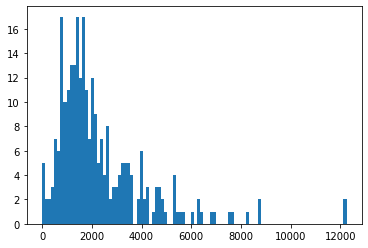

In [6]:
fig, ax = plt.subplots()
_ = ax.hist(total_counts.median(axis=0), bins=100)
#sorted(total_counts.loc[idx_daisy,:].median(axis=0))

Based on that I removed samples with either 0 or very low median counts (<500). 14 samples were removed. Given the already low amount of samples I didn't want to go further than this. In the below code, and after removal of samples, I am now also keeping track of cancer and control IDs separately.

In [7]:
total_counts = total_counts.loc[:, total_counts.median(axis=0) > 500]
sampleids_all = sampleids_all.intersection(total_counts.columns)
sampleids_cancer = sampleids_all.intersection(
    meta_data.columns[meta_data.loc['Cancer type'] == 'Daisy'])
sampleids_control = sampleids_all.intersection(
    meta_data.columns[meta_data.loc['Clinical diagnosis'] == 'CONTROL'])
assert len(sampleids_control) + len(sampleids_cancer) == len(sampleids_all)
total_counts.shape

(225, 258)

Below, I plotted the median counts per sample separately for cancer and control samples to look for possible differences, but things look ok.

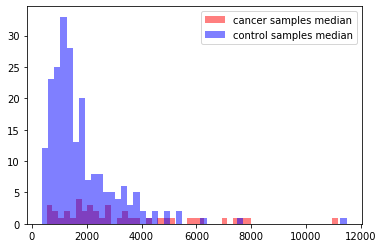

In [8]:
fig, ax = plt.subplots()
ax.hist(total_counts.loc[idx_daisy, total_counts.columns.isin(sampleids_cancer)].median(axis=0), 
        bins=50, fc=(1,0,0,0.5), label="cancer samples median")
ax.hist(total_counts.loc[idx_daisy, total_counts.columns.isin(sampleids_control)].median(axis=0),
        bins=50, fc=(0,0,1,0.5), label="control samples median")
_ = ax.legend()

Next, I looked at mutations in the total_counts table. Daisy-related variants have higher counts in cancer samples than in control samples, therefore there should be some signal in the data to train a CNN. On a side note, when looking at the variants related to all the other cancer types one can see the same trend. Differentiating multiple cancer types from each other should be much more difficult.

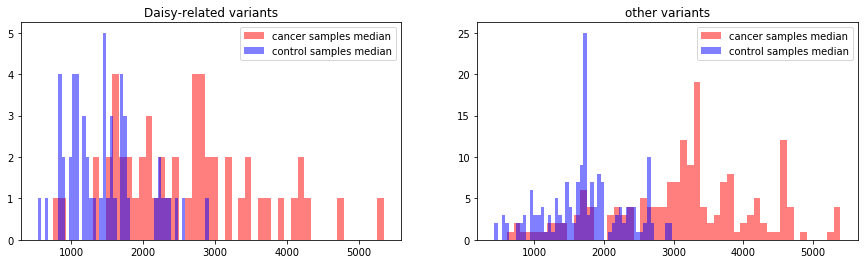

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax.flat[0].hist(total_counts.loc[idx_daisy, total_counts.columns.isin(sampleids_cancer)].median(axis=1), 
                 bins=50, fc=(1,0,0,0.5), label="cancer variants median")
ax.flat[0].hist(total_counts.loc[idx_daisy, total_counts.columns.isin(sampleids_control)].median(axis=1),
                 bins=50, fc=(0,0,1,0.5), label="control samples median")
ax.flat[0].legend()
ax.flat[0].set_title("Daisy-related variants")
ax.flat[1].hist(total_counts.loc[np.invert(idx_daisy), total_counts.columns.isin(sampleids_cancer)].median(axis=1), 
                bins=50, fc=(1,0,0,0.5), label="cancer samples median")
ax.flat[1].hist(total_counts.loc[np.invert(idx_daisy), total_counts.columns.isin(sampleids_control)].median(axis=1),
                bins=50, fc=(0,0,1,0.5), label="control samples median")
ax.flat[1].legend()
_ = ax.flat[1].set_title("other variants")

Moving on to the meta data, I first explored the clinical data to find potential features beyond specific mutation counts. I removed all non-daisy cancer samples and plotted some features for daisy and control samples. "Comorbidities: Unknown", "Comorbidities: Kidney Disease", "Risk Factor: Medical Condition" and some others might be useful downstream.

In [10]:
meta_data = meta_data.loc[:, meta_data.columns.isin(total_counts.columns)].transpose()

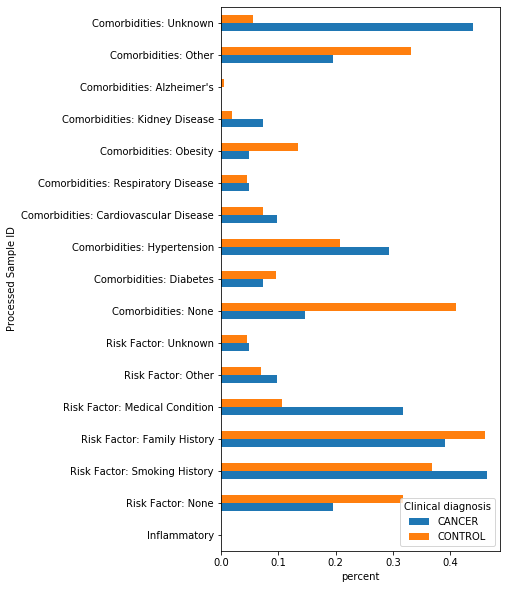

In [11]:
# clinical diagnosis meta data
group_size = meta_data.groupby(['Clinical diagnosis']).size()
grouped = meta_data.groupby(['Clinical diagnosis'])[meta_data.columns[2:19]].sum()
for meta in grouped:
    grouped[meta] /= group_size 
ax = grouped.transpose().plot(kind='barh', figsize=(5,10))
_ = ax.set_xlabel("percent")

I also looked at the remaining meta data (not all visualized). "Age" might be another useful feature and some other data points can be useful to detect biases, most notably, the gender ratio: while females are overrepresented in the Control group, they are underrepresented in the cancer cohort. This can, of course, hint to a cancer type more prevalent in male, but since male and females are  known to naturally have different mutation rates this might also introduce noise into the data. Given the low number of samples in my data set I did not control for the male/female ratio, but it is something I would consider in "real life". 

Batch numbers are also available and count and meta data should be looked at on a per-batch basis to look for batch effects which are common in sequencing experiments. I did not do this here. "Source" is one last example that looks a little suspicious, because of the difference between control and cancer samples. I don't know what it means (source of the sample? different databases or hospitals...), but this can be another confounding factor.

Gender,F,M
Clinical diagnosis,,
CANCER,0.365854,0.634146
CONTROL,0.755760,0.244240


Ancestry,ASIAN,BLACK OR AFRICAN AMERICAN,OTHER,WHITE
Clinical diagnosis,,,,
CANCER,0.050000,0.025000,0.050000,0.875000
CONTROL,0.013889,0.018519,0.074074,0.893519


Source,1,2
Clinical diagnosis,,
CANCER,0.560976,0.439024
CONTROL,1.000000,0.000000


Batch number,Batch3,Batch4,Batch5,Batch6
Clinical diagnosis,,,,
CANCER,0.268293,0.390244,0.317073,0.024390
CONTROL,0.193548,0.059908,0.447005,0.299539


Location of extraction,1
Clinical diagnosis,
CANCER,1.0
CONTROL,1.0


Flow cell name,FlowCell_1,FlowCell_2
Clinical diagnosis,,
CANCER,0.731707,0.268293
CONTROL,0.806452,0.193548


Bucket number,0,1,2,3,-
Clinical diagnosis,,,,,
CANCER,0.000000,0.219512,0.121951,0.000000,0.658537
CONTROL,0.004608,0.341014,0.216590,0.184332,0.253456


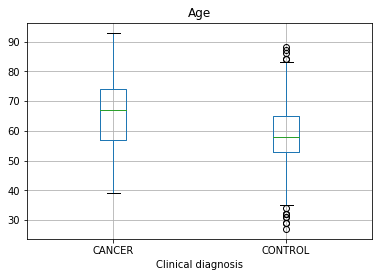

In [12]:
# some other meta data
for meta in ['Gender', "Ancestry", 'Source', 'Batch number', 'Location of extraction',
             "Flow cell name", 'Bucket number']:
    display(pd.crosstab(meta_data['Clinical diagnosis'], meta_data[meta], normalize='index'))
    
for meta in ["Age"]:
    meta_data.boxplot(column=meta, by="Clinical diagnosis")
    plt.suptitle("")

Next, I started to prepare the actual training data for the CNN. I checked whether the order of variants in the total_counts and specific_counts table is identical (which is the case).

In [13]:
total_counts_variants = pd.read_excel("QG_DS_ML_hiringChallenge.xlsx", sheet_name=2,
                                      usecols="A:K", header=1, index_col=0)
specific_counts_variants = pd.read_excel("QG_DS_ML_hiringChallenge.xlsx", sheet_name=1,
                                         usecols="A:K", skiprows=range(47), nrows=225, index_col=0)
total_counts_variants.equals(specific_counts_variants)

True

I then extracted the specific_counts table from the .xlsx file, removed all unneeded samples and normalized the counts by dividing through the total_counts table to get relative frequencies.

In [14]:
specific_counts = pd.read_excel("QG_DS_ML_hiringChallenge.xlsx", sheet_name=1, usecols="L:MX", 
                                 skiprows=range(47), nrows=225)
specific_counts = specific_counts.loc[:,total_counts.columns]
specific_counts = (specific_counts / total_counts).transpose()
specific_counts = specific_counts.fillna(0.0)

I created the the label vector "y", where 0 stands for a control sample and 1 for a daisy cancer sample. This is what the network predicts later on.

In [15]:
# 0 == control, 1 == cancer
y = [0] * specific_counts.shape[0]
for idx, sampleid in enumerate(specific_counts.index):
    if sampleid in sampleids_cancer:
        y[idx] = 1
y = np.array(y)

The main input "X" for the CNN is represented by the relative frequencies of the specific_counts table computed above. Each sample consists of 225 variants, therefore I reshaped every sample into a 15x15 matrix. This allows me to later apply a 2D CNN. Moreover, I prepared some promising looking meta data features (see code below) as "X_additional". Usage of the additional input is explained in the next step.

In [16]:
X = []
X_additional = []
for sample in specific_counts.index:
    X.append(np.array(specific_counts.loc[sample]).reshape((15,15,1)))
    x = list(meta_data.loc[sample, ["Comorbidities: Unknown", "Risk Factor: Smoking History", 
                                    "Risk Factor: Medical Condition", "Age", "Gender"]])
    x[-1] = 1 if x[-1]=="M" else 0
    X_additional.append(np.array(x))
X = np.array(X)
X_additional = np.array(X_additional)

Finally, I trained a CNN. I played a little bit with the network architecture and some hyperparameters and settled for the following simple model: a single convolutional layer with 15 kernels (ReLU activation), followed by max pooling, followed by a dense layer with 30 neurons (ReLU activations), followed by dropout followed by the output neuron with sigmoid activation for binary classification. The mentioned 15x15 matrices are our main input and fed through the complete network. The 5 additional meta data features are introduced in the dense layer by creating 5 additional neurons (for a total of 35). All weights in all layers are L2 regularized.

Given the low amount of data, even a small network produced more or less unstable predictive results. For training and evaluation I performed 20 5-fold cross-validations to get a better sense of false positive and false negative rates. During training I also used class weights ("class_weights" variable below) to artificially increase the loss of the minority cancer class. This helps a lot to reduce false predictions and it also shifts the optimal probability cutoff towards the usual 0.5.

Overall, and given the amount of input data, false positive and false negative rates are on average around 0.2, as shown in the box plots below.

In [18]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input, concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model as KModel
from keras.regularizers import l2
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


def build_model():
    main_input = Input(shape=(15,15,1))
    model = Conv2D(filters=15, kernel_size=(5,5), activation="relu", 
                   kernel_regularizer=l2(0.01))(main_input)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    addi_input = Input(shape=(5,))
    model = concatenate([model, addi_input])
    model = Dense(units=30, activation='relu',
                  kernel_regularizer=l2(0.01))(model)
    model = Dropout(rate=0.5)(model)
    model = Dense(units=1, activation='sigmoid')(model)
    model = KModel(inputs=[main_input, addi_input], outputs=[model])
    model.compile(loss="binary_crossentropy", optimizer=Adam())
    return model


# 20x 5-fold training
fprs, fnrs = [], []
for idx in range(20):
    print("starting round {}...".format(idx+1))
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in kf.split(X, y):
        # split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_addi_train, X_addi_test = X_additional[train_index], X_additional[test_index]
        # train model
        model = build_model()
        class_weights = {0: 1.0, 1: (len(y_train)-y_train.sum())/y_train.sum()}
        callbacks = [EarlyStopping('val_loss', patience=200)]
        model.fit([X_train, X_addi_train], y_train, epochs=5000, verbose=0, 
                   batch_size=X_train.shape[0], class_weight=class_weights,
                   validation_data=([X_test, X_addi_test], y_test), callbacks=callbacks)
        # save FPR and FNR 
        predictions = model.predict([X_test, X_addi_test]) > 0.5
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        fprs.append(fp/(fp+tn))
        fnrs.append(fn/(tp+fn))
        K.clear_session()
        K.reset_uids()

starting round 1...
starting round 2...
starting round 3...
starting round 4...
starting round 5...
starting round 6...
starting round 7...
starting round 8...
starting round 9...
starting round 10...
starting round 11...
starting round 12...
starting round 13...
starting round 14...
starting round 15...
starting round 16...
starting round 17...
starting round 18...
starting round 19...
starting round 20...


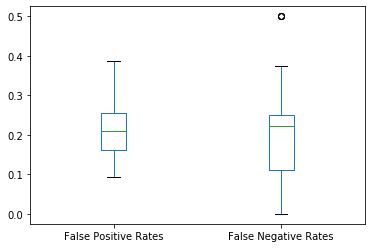

In [19]:
df = pd.DataFrame(list(zip(fprs, fnrs)), 
                  columns=["False Positive Rates", "False Negative Rates"])
_ = df.plot(kind="box")